# Project 3: Cointegration and Pairs Trading
## 1. Integration
Cointegration is when two (or more) signals $X_t$ and $Y_t$ that are not themselves stationary can be combined such that the resultant signal is stationary. Suppose $X_t$ and $Y_t$ are related as follows:
$$\begin{align}
Y_t = \alpha + \beta X_t + \epsilon_t
\end{align}$$
If $\epsilon_t$ is stationary, then $X_t$ and $Y_t$ are said to be cointegrating, naturally leading to a pairs trading approach - whenever a trade signal arrives, one buys $N$ units of $Y$ and sells $\beta N$ units of $X$, and vice versa. There exist improvements to the ADF test such as the Cointegrated ADF (CADF) test and the Johansen test that effectively take two signals, check for cointegration and return the optimal hedge ratio $\beta$ between the two signals. In this project, we focus on the CADF test. The CADF test is implemented by treating either of the two signals as the base signal, and the other as the target signal. The target signal is then regressed on the base signal using OLS regression. The residual of the regression $\epsilon_t$ is then tested using an ADF test. The procedure is then repeated by swapping the base and target signals being used, and the test with the more negative ADF test statistic determines which OLS regression coefficients to use in combining the signals to produce a cointegrating one.

## 2. Data Source
For the two signals, we continue with FX exchange rates. We examine EUR vs. GBP and SEK vs. GBP, since we expect the two signals to be well correlated due to geographical proximity. We would like to select a time where neither exchange rate was stationary. Hence, instead of the earlier time window from 2016 to 2019, we instead focus on the period from late 2012 to late 2016. Rather than stationarity, there is an extremely strong trend in both exchange rates during this period. However, from both plots below, you can see that both show strong correlations.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


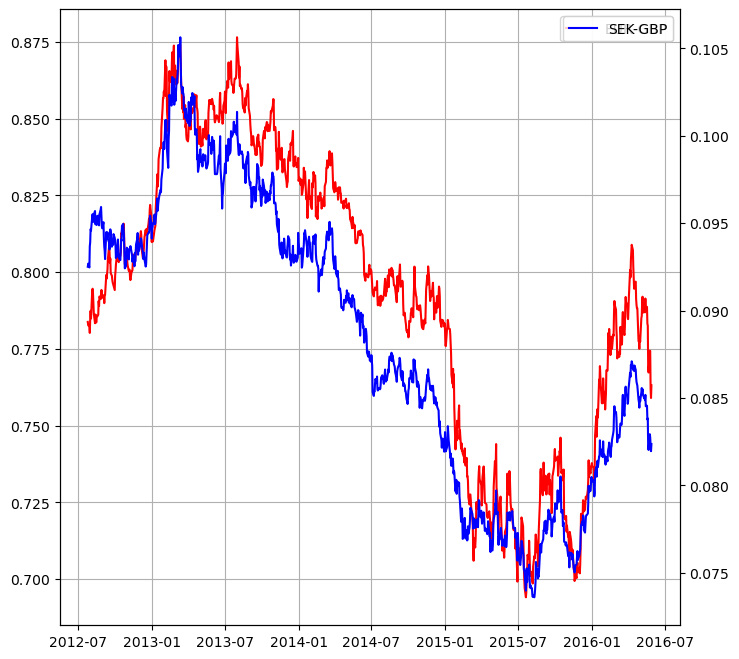

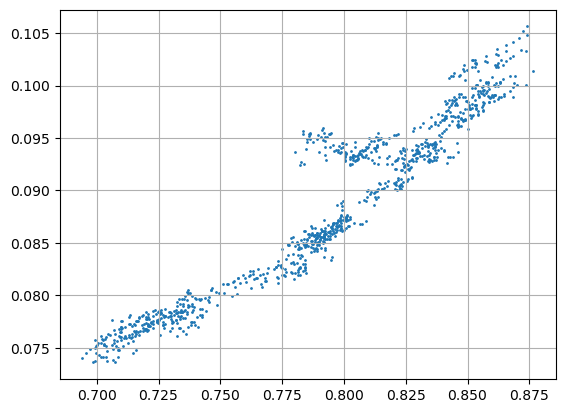

In [4]:
# Imports 
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Get EUR and CHF exchange rate data with GBP
window_start = 1800
window_end = 2800
df_eur = yf.download("EURGBP=X", start='2005-08-21', end='2025-08-21', interval='1d', auto_adjust=True)
df_sek = yf.download("SEKGBP=X", start='2005-08-21', end='2025-08-21', interval='1d', auto_adjust=True)
y_eur = np.array([y[0] for y in df_eur['Close'].values.tolist()])
y_sek = np.array([y[0] for y in df_sek['Close'].values.tolist()])
t_eur = df_eur['Close'].index.tolist()
t_sek = df_sek['Close'].index.tolist()

# Some data cleanup
missing_ts = [t for t in t_eur if t not in t_sek]
y_eur = [y for y,t in zip(y_eur, t_eur) if t not in missing_ts]
t_eur = [t for t in t_eur if t not in missing_ts]

# Plot data
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

ax1.plot(t_eur[window_start:window_end], y_eur[window_start:window_end], color='red')
ax2.plot(t_sek[window_start:window_end], y_sek[window_start:window_end], color='blue');
ax1.grid()
ax1.legend(['EUR-GBP'])
ax2.legend(['SEK-GBP'])

plt.figure(2)
plt.scatter(y_eur[window_start:window_end], y_sek[window_start:window_end], marker='o', s=1)
plt.grid()


In [5]:
# Setup
import statsmodels.api as sm 
y_eur_test = y_eur[window_start:window_end]
y_sek_test = y_sek[window_start:window_end]
t_test = t_eur[window_start:window_end]

# Least squares regression of eur vs sek
x = sm.add_constant(y_sek_test)
res = sm.OLS(y_eur_test, x).fit() #x = sek, y = eur
residual = y_eur_test - (res.params[0] + res.params[1]*y_sek_test)

# Run Augmented Dickey-Fuller test
result = adfuller(residual)
print(result)

# Swap the order
x = sm.add_constant(y_eur_test)
res = sm.OLS(y_sek_test, x).fit() #x = sek, y = eur
residual = y_sek_test - (res.params[0] + res.params[1]*np.array(y_eur_test))

# Run Augmented Dickey-Fuller test
result = adfuller(residual)
print(result)

(np.float64(-3.7527465355411467), np.float64(0.0034295174252757426), 3, 996, {'1%': np.float64(-3.4369325637409154), '5%': np.float64(-2.8644462162311934), '10%': np.float64(-2.568317409920808)}, np.float64(-8700.54862817476))
(np.float64(-3.2830979719761983), np.float64(0.015651109050279385), 2, 997, {'1%': np.float64(-3.4369259442540416), '5%': np.float64(-2.8644432969122833), '10%': np.float64(-2.5683158550174094)}, np.float64(-12207.07996722534))


From this, we can see that the model $Y^{EUR}_t = \alpha + \beta Y^{SEK}_t + \epsilon_t$ has a better ADF test statistic, and hence we can use this for a pairs trading algorithm. The idea is that since $\epsilon_t = Y^{EUR}_t - ( \alpha + \beta Y^{SEK}_t )$ is stationary, we simultaneously go long on EUR-GBP by $x$ units while going short on SEK-GBP by $\beta x$ units using a similar Z-score mean-reversion algorithm as earlier. A similar analysis to part 1 yields a half-life of 32 days that we can use for our moving average window. 

32.002759800627224


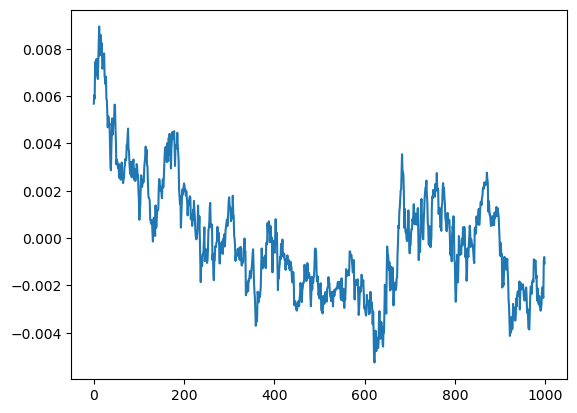

In [6]:
# Regression to find half life
y = residual
y_diff = y[1:]-y[:-1]
t = t_test

# Build an AR(1) model
model_fit = sm.OLS(y_diff,-y[:-1]).fit() # Y, X
half_life = np.log(2)/model_fit.params[0]
print(half_life)
plt.plot(residual)